In [1]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


### **All imports needed to run the program:**

In [22]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import streamlit as st
import seaborn as sns

from sklearn import metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, MaxPooling1D, Conv1D
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

#### *If running it on Google Colab:*

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path_to_data = '/content/drive/Shared drives/mlproj/scrubbed.csv'

Mounted at /content/drive


### **Upload the dataset and extract the relevant column (datetime):**
We are only predicting the next UFO sightings in California, so we only need the rows that have 'ca' in their `state` column. Also, we don't need all other columns except for `datetime` to make this prediction.

In [5]:
df = pd.read_csv(path_to_data)

# List of columns to drop
columns_to_drop = ['comments', 'city', 'date posted', 'shape', 'duration (seconds)', 'duration (hours/min)', 'country', 'state', 'latitude', 'longitude ']

# Filter for rows where 'state' is 'ca' and 'country' is 'us', and drop specified columns and cities
df_filtered = df[(df['state'] == 'ca') & (df['country'] == 'us')].drop(columns=columns_to_drop, axis=1)

### **Separate ``datetime`` column into two columns ``Date`` and ``Time``:**
We are not predicting the exact time of occurence, and therefore we don't need the timing information. However, because the dataset has both date and time together in one column, we want to separate the two and keep the `Date` column only.


In [6]:
df_filtered[['Date', 'Time']] = df_filtered['datetime'].str.split(' ', n=1, expand=True)
data = df_filtered.drop(columns=['datetime', 'Time'])

# Display the filtered DataFrame
display(data)

,Date
10,10/10/1968
30,10/10/1979
45,10/10/1989
63,10/10/1995
72,10/10/1998
...,...
80299,9/9/2012
80305,9/9/2012
80310,9/9/2012
80316,9/9/2013


#### For context, the following is a bar graph for the number of UFO sightings occurred in California by city. However, we only included the cities where more than 50 sightings were observed between 1947 and 2013.

In [8]:
# Filter for rows where 'state' is 'ca' and 'country' is 'us', and drop specified columns and cities
# List of columns to drop
columns_to_drop = ['comments', 'date posted', 'shape', 'duration (seconds)', 'duration (hours/min)', 'country', 'state', 'latitude', 'longitude ']
df_ = df[(df['state'] == 'ca') & (df['country'] == 'us')].drop(columns=columns_to_drop, axis=1)

df_[['Date', 'Time']] = df_['datetime'].str.split(' ', n=1, expand=True)
date_and_city = df_.drop(columns=['datetime', 'Time'])

# Display the filtered DataFrame
display(date_and_city.head(8))

,city,Date
10,hawthorne,10/10/1968
30,san diego,10/10/1979
45,calabasas,10/10/1989
63,oakland,10/10/1995
72,hollywood,10/10/1998
82,martinez,10/10/1999
85,san diego,10/10/1999
87,hayward,10/10/1999


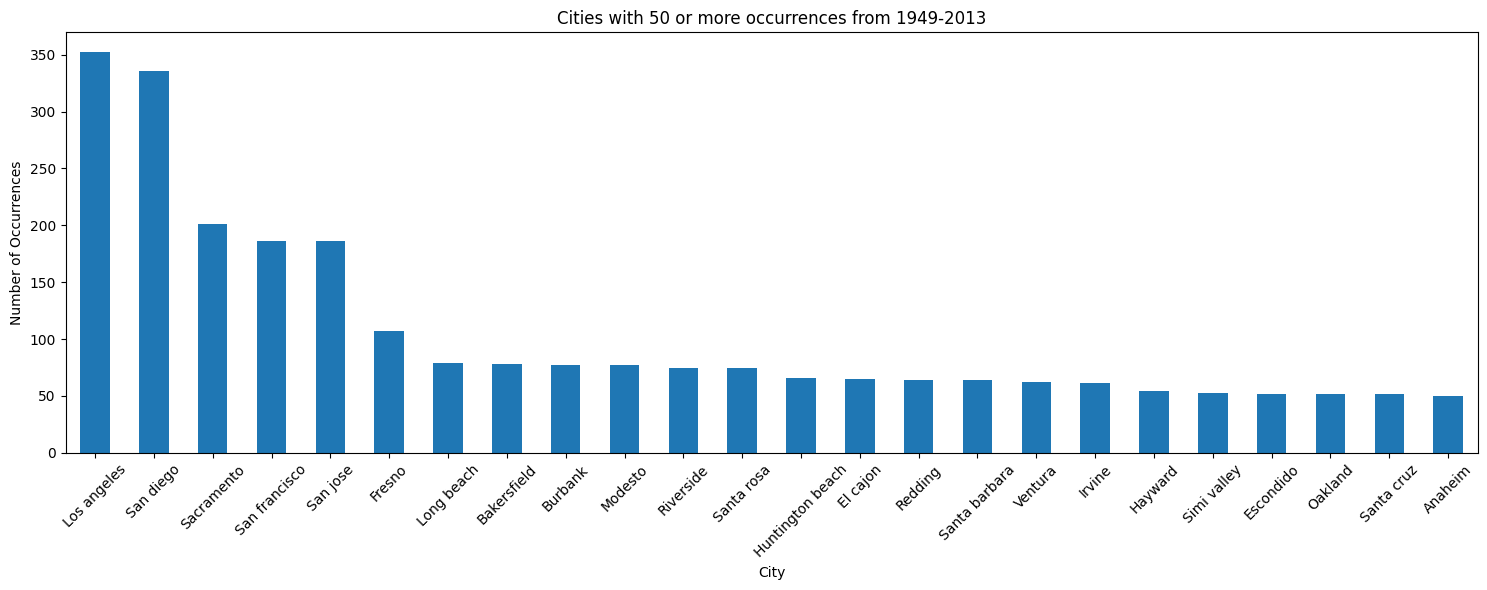

In [17]:
# Capitalize the first letter of each city name
date_and_city['city'] = date_and_city['city'].str.capitalize()

# Group by 'city' and count occurrences
city_occurrences = date_and_city['city'].value_counts()

# Omit cities with less than 50 occurrences
city_occurrences = city_occurrences[city_occurrences >= 50]

# Plot bar chart
plt.figure(figsize=(15, 6))
city_occurrences.plot(kind='bar')
plt.title('Cities with 50 or more occurrences from 1949-2013')
plt.xlabel('City')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Add extra information to set up for prediction:**
Here we add an extra column named `Observed` which shows whether a sighting was observed on the corresponding date. Since we only have the dates of UFO sightings observed, we want to fill the dates in between occurences with 0s to indicate no observations.

In [18]:
# Convert the current date format MM/DD/YYY to YYYY-MM-DD
data['Date'] = pd.to_datetime(data['Date'])
# Add an additional column
data['Observed'] = 1
# Remove duplicate dates as we don't need them
data = data[~data['Date'].duplicated()]
# Sort the dates from earliest to latest and fill the rows in between observed dates with 0
r = pd.date_range(start=data['Date'].min(), end=data['Date'].max())
data = data.set_index('Date').reindex(r).fillna(0.0).rename_axis('Date').reset_index()

display(data)

,Date,Observed
0,1937-08-15,1.0
1,1937-08-16,0.0
2,1937-08-17,0.0
3,1937-08-18,0.0
4,1937-08-19,0.0
...,...,...
28020,2014-05-03,1.0
28021,2014-05-04,1.0
28022,2014-05-05,1.0
28023,2014-05-06,0.0


### **Feature engineering:**
Prediction of next release dates heavily relies on feature engineering because we do not have any features besides the date itself. Therefore, we add extra columns to feed more information about the dates into our model.

In [19]:
# Extract/create more information about the dates
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
# The number of business day corresponding to the date (1st business day starts from 0)
# for example, 05/07/2014 was the 5th business day of that month, so it's shown as 4 in the chart
data['Workday_N'] = np.busday_count(
                    data['Date'].values.astype('datetime64[M]'),
                    data['Date'].values.astype('datetime64[D]'))
# Which day of the week that day was (0 to 6 for Monday to Sunday)
# for example, 08/15/1937 was Sunday, so it's shown as 6 in the chart
data['Week_day'] = data['Date'].dt.weekday
# Which week of the month that month was
# for example, the week of 08/16/1937 was the 4th week of that month
data['Week_of_month'] = (data['Date'].dt.day
                         - data['Date'].dt.weekday - 2) // 7 + 2
data['Weekday_order'] = (data['Date'].dt.day + 6) // 7
# Set the 'Date' itself as the index for better readability
data = data.set_index('Date')
display(data)

,Observed,Month,Day,Workday_N,Week_day,Week_of_month,Weekday_order
Date,,,,,,,
1937-08-15,1.0,8,15,10,6,3,3
1937-08-16,0.0,8,16,10,0,4,3
1937-08-17,0.0,8,17,11,1,4,3
1937-08-18,0.0,8,18,12,2,4,3
1937-08-19,0.0,8,19,13,3,4,3
...,...,...,...,...,...,...,...
2014-05-03,1.0,5,3,2,5,1,1
2014-05-04,1.0,5,4,2,6,1,1
2014-05-05,1.0,5,5,2,0,2,1


### Let's display the correlation matrix to see which features are most related to predicting the observation:

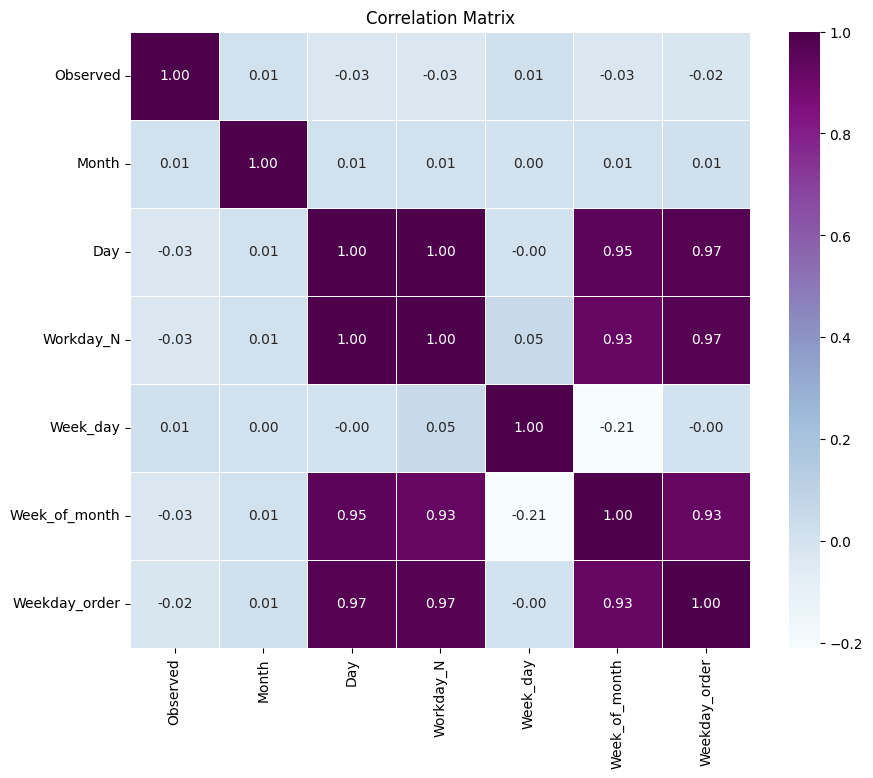

In [39]:
# Generate correlation matrix
correlation_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### **Train and test split:**
Split the preprocessed dataset with a ratio of 70:30 with the ``Observed`` column values as the target variables.

In [20]:
x = data.drop(['Observed'], axis=1)
y = data['Observed']  # Target variable

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### **Train and test the data:**
We used *RandomForestClassifier* because this model often results in higher accuracy compared to individual decision trees, as it reduces overfitting and variance. This is because it builds multiple trees and averages their predictions, which helps generalize well to unseen data.

But first, we do GridSearch for the best parameters to get high accuracy.

In [ ]:
# GridSearch parameters:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Model definition:
model = RandomForestClassifier(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
# Fit the grid search to the data
grid_search.fit(x_train, y_train)
# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_
# Predict using the best model
rf_pred = best_model.predict(x_test)
# Print classification report
print(classification_report(y_test, rf_pred))

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      7001
         1.0       0.55      0.04      0.07      1407

    accuracy                           0.83      8408
   macro avg       0.69      0.52      0.49      8408
weighted avg       0.79      0.83      0.77      8408



**Confusion matrix on the training result:**

In [ ]:

rf_matrix = metrics.confusion_matrix(rf_pred, y_test)
tn, fp, fn, tp = rf_matrix.ravel()
print(f"\nConfusion Matrix:")
print(rf_matrix)
print(f"\nTP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn}")


Confusion Matrix:
[[6956 1352]
 [  45   55]]

TP: 55
TN: 6956
FP: 1352
FN: 45


### **Predict future date:**
We now create DataFrame with future dates for prediction and use our trained RandomForest model to predict future UFO sightings for one year ahead.

In [ ]:
x_predict = pd.DataFrame(pd.date_range(date.today(), (date.today() +
            relativedelta(years=1)),freq='d'), columns=['Date'])

x_predict['Month'] = x_predict['Date'].dt.month
x_predict['Day'] = x_predict['Date'].dt.day
x_predict['Workday_N'] = np.busday_count(
                x_predict['Date'].values.astype('datetime64[M]'),
                x_predict['Date'].values.astype('datetime64[D]'))
x_predict['Week_day'] = x_predict['Date'].dt.weekday
x_predict['Week_of_month'] = (x_predict['Date'].dt.day -
                              x_predict['Date'].dt.weekday - 2)//7+2
x_predict['Weekday_order'] = (x_predict['Date'].dt.day + 6) // 7

x_predict = x_predict.set_index('Date')
prediction = best_model.predict(x_predict)
prediction = pd.DataFrame(prediction, columns=['Prediction'])
prediction['Date'] = x_predict.index

next_sightings = prediction[prediction['Prediction'] == 1]
next_sightings = next_sightings.reset_index()
next_sightings = next_sightings.drop(columns=['index'])
display(next_sightings)

,Prediction,Date
0,1.0,2024-06-01
1,1.0,2024-06-15
2,1.0,2024-06-30
3,1.0,2024-07-01
4,1.0,2024-07-15


### **UI implementation:**

In [ ]:
from IPython.display import HTML

s  = '<script type="text/Javascript">'
s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
s += 'win.document.body.innerHTML = \'' + next_sightings.to_html().replace("\n",'\\') + '\';'
s += '</script>'
# s = next_sightings.to_html()
HTML(s)